In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
from bokeh.resources import INLINE
from bokeh.models import LinearColorMapper, ColumnDataSource, ColorBar, LabelSet, Legend, GMapOptions
from bokeh.plotting import figure, show, gmap, output_file
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import output_notebook

In [3]:
from OSMPythonTools.api import Api
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from OSMPythonTools.nominatim import Nominatim

In [4]:
from catboost import CatBoostRegressor, Pool

In [5]:
from eli5 import explain_weights_catboost

/Users/olgakhamtsova/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import warnings
warnings.filterwarnings("ignore")
import os
import shap

In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
%matplotlib inline

In [9]:
sns.set(rc={'figure.figsize':(12,8)})

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [11]:
tqdm.pandas()

In [12]:
output_notebook()

Loading BokehJS ...

In [13]:
def get_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [14]:
def merc_from_arrays(lats, lons):
    r_major = 6378137.000
    x = r_major * np.radians(lons)
    scale = x / lons
    y = 180.0 / np.pi * np.log(np.tan(np.pi / 4.0 + lats * (np.pi / 180.0) / 2.0)) * scale
    return (x, y)

In [15]:
def plot_points(data, target, palette='Turbo256'):
    # prepare data
    source = ColumnDataSource(data)
    
    # init tooltips
    tooltips = [('Address', '@name'), ('Price', '@price')]
    
    # init figure
    p = figure(x_axis_type='mercator', y_axis_type='mercator', 
               output_backend='webgl', tooltips=tooltips)

    # figure parameters
    p.border_fill_color = 'white'
    p.plot_height = 600
    p.plot_width = 800
    p.title.text = f'Карта стоимости недвижимости'
    p.xaxis.axis_label = 'Широта (меркатор)'
    p.yaxis.axis_label = 'Долгота (меркатор)'

    # add map layer to figure
    tile_provider = get_provider(Vendors.OSM)
    p.add_tile(tile_provider)
    
    # init palette
    exp_cmap = LinearColorMapper(palette=palette, low=min(data[target]), high=max(data[target]))
    
    # add grid
    points = p.circle(x='lat_merc', y='lon_merc', size=12, alpha=0.5, source=source, 
                      fill_color={'field': target, 'transform': exp_cmap})
    
    # add color bar
    bar = ColorBar(color_mapper=exp_cmap, width=18, location=(0, 0))
    
    p.add_layout(bar)
    
    return show(p, notebook_handle=True)

In [16]:
def osm_count_objects(bbox: tuple, obj_type: str):
    overpass = Overpass()
    query = overpassQueryBuilder(bbox=bbox, elementType='node', selector=f'{obj_type}', out='count')
    result = overpass.query(query)
    return result.countElements()

In [17]:
df_listings_summary = pd.read_csv('../FinalWork/berlin-airbnb-data/listings_summary.csv')

In [18]:
s2 = '":@.-()/{}'
for row in df_listings_summary.amenities:
    s1 = row
    for sim in s2:
        s1 = s1.replace(str(sim), '')
    R = s1.split(",")

df_listings_summary["amenities"] = df_listings_summary["amenities"].apply(lambda x: x[1:-1].replace("\"", "").split(","))


df_listings_summary["security_deposit"].fillna("$0.00", inplace=True)
df_listings_summary["cleaning_fee"].fillna("$0.00", inplace=True)
df_listings_summary["extra_people"].fillna("$0.00", inplace=True)

In [19]:
def remove_s(str_price):
    if "," in str_price:
        str_price = str_price.replace(",", "")
    else:
        pass
    return str_price[1:]


for s_column in ["price", "security_deposit", "cleaning_fee", "extra_people"]:
    price_no_s = df_listings_summary[s_column].apply(remove_s)
    df_listings_summary[s_column] = price_no_s

In [20]:
df_listings_summary["price"] = df_listings_summary["price"].astype("float")
df_listings_summary["host_is_superhost"].fillna("f", inplace=True)
df_listings_summary["host_identity_verified"].fillna("f", inplace=True)
df_listings_summary["bedrooms"].fillna(1.0, inplace=True)

In [21]:
columns_to_keep = ["id", "description", "neighbourhood_cleansed", "neighbourhood_group_cleansed",
                   "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "bed_type",
                   "amenities", "square_feet", "price", "security_deposit", "cleaning_fee", "guests_included", 
                   "extra_people", "minimum_nights", "instant_bookable", "cancellation_policy",
                   "host_identity_verified", "is_business_travel_ready", "host_is_superhost", "latitude", "longitude"]

In [22]:
df_selected = df_listings_summary[columns_to_keep].set_index('id')

In [23]:
df_raw = df_selected[(df_selected.price 
                                 <= np.percentile(df_selected["price"],
                                99.5)) & (df_selected.price > 0)]

In [24]:
selected = []
df_raw["is_entire_apt"] = df_raw["room_type"]=="Entire home/apt"
selected.append("is_entire_apt")

In [25]:
df_raw["hair_dryer"] = df_raw["amenities"].apply(lambda x: '"Hair dryer"' in x)
df_raw["lap_friendly"] = df_raw["amenities"].apply(lambda x: '"Laptop friendly workspace"' in x)
df_raw["Washer"] = df_raw["amenities"].apply(lambda x: "Washer" in x)
for i in ["hair_dryer", "lap_friendly", "Washer"]:
    selected.append(i)

In [26]:
df_raw["minimum_nights_more_1"] = df_raw["minimum_nights"].apply(lambda x: 'True' if x > 1 else 'False')
selected.append("minimum_nights_more_1")

In [27]:
df_raw["cleaning_fee"] = df_raw["cleaning_fee"].astype("float")
selected.append("cleaning_fee")

In [28]:
selected.append("accommodates")

In [29]:
selected.append("host_is_superhost")
selected.append("host_identity_verified")
selected.append("instant_bookable")

In [30]:
df_raw["cancellation_not_flexible"] = df_raw["cancellation_policy"]!="flexible"
selected.append("cancellation_not_flexible")

In [31]:
df_raw["host_is_superhost"] = df_raw["host_is_superhost"]=="t"
df_raw["host_identity_verified"] = df_raw["host_identity_verified"]=="t"
df_raw["instant_bookable"] = df_raw["instant_bookable"]=="t"
df_raw["minimum_nights_more_1"] = df_raw["minimum_nights_more_1"]=="t"

In [32]:
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")
df_raw['size'] = df_raw['size'].astype(float)

In [33]:
df_raw["security_deposit"] = df_raw["security_deposit"].astype("float")
df_raw["extra_people"] = df_raw["extra_people"].astype("float")
df_raw["bathrooms"].fillna(1.0, inplace=True)

In [34]:
# Чтобы не потерять значительную часть полезной информации, не будем избавляться от пропущенных значений.
# Заполним их значениями, полученными с помощью алгоритма машинного обучения. Для этого используем только численные значения
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'size']]
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)
y_train = train_data['size']

In [35]:
from sklearn.linear_model import LinearRegression
lg = LinearRegression()
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
y_test = lg.predict(X_test)

In [37]:
# Теперь когда у нас есть значения площади преобразуем y_test в датасет
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']

In [38]:
# Чтобы объединить X_test и y_test нужно сопоставить индексы обеих частей
ind = pd.DataFrame(X_test.index)
ind.columns = ['ind']
y_test = pd.concat([y_test, ind], axis=1)
y_test.set_index(['ind'], inplace=True)
new_test_data = pd.concat([X_test, y_test], axis=1)

In [39]:
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

In [40]:
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'size'], 
            axis=1, inplace=True)

In [41]:
df = pd.concat([sub_df_new, df_raw], axis=1)

In [42]:
# 98,5% данных ограничиваются площадью 300 кв м. Все что больше 300 кв м, а так же  нулевые значения считаем выбросами. 
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [43]:
selected.append("size")

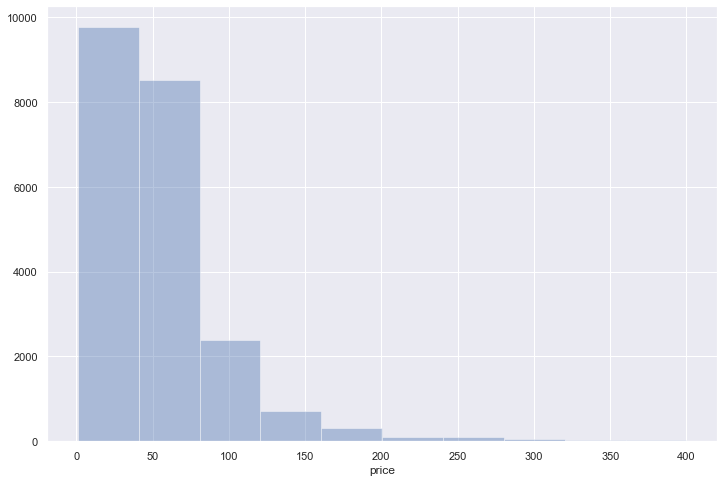

In [44]:
sns.distplot(a=df['price'], bins=10, kde=False)

In [45]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
df['lat_merc'] = df['latitude']
df['lon_merc'] = df['longitude']

In [48]:
plot_points(data=df, target='price')

TypeError: __init__() got an unexpected keyword argument 'x_axis_type'

In [49]:
nominatim = Nominatim()
areaId = nominatim.query('Berlin Germany').areaId()

In [50]:
areaId

3600062422

In [51]:

overpass = Overpass()
query = overpassQueryBuilder(areaId, elementType='node', selector='"amenity"="restaurant"', out='count')
result = overpass.query(query)
result.countElements()

4079

In [52]:
# Функция получения объектов по ID локации
def get_poi_data(area_id: int, obj_type: str):
    overpass = Overpass()
    query = overpassQueryBuilder(area=area_id, elementType='node', selector='{}'.format(obj_type), out='body')
    result = overpass.query(query, timeout=60)
    return result.toJSON()['elements']

In [53]:
# Функция парсинга полученных данных
def parse_poi_data(json_data):
    lat, lon, tag = [], [], []
    for item in tqdm(json_data):
        if any(['tourism' in item['tags']]):
            lat.append(item['lat'])
            lon.append(item['lon'])
            tag.append(item['tags'])
    return pd.DataFrame([lat, lon, tag], index=['latitude', 'longitude', 'tags']).T

In [54]:
df_poi = pd.DataFrame()
for obj_type in ['tourism']:
    json_data = get_poi_data(area_id=areaId, obj_type=obj_type)
    df_poi_parsed = parse_poi_data(json_data)
    df_poi_parsed['obj_type'] = obj_type
    df_poi = df_poi.append(df_poi_parsed)

In [55]:
def get_obj_type(row, obj_type):
    return row[obj_type]

In [56]:
df_poi['obj_detail'] = df_poi.progress_apply(lambda x: get_obj_type(row=x['tags'], 
                                                                    obj_type=x['obj_type']), axis=1)

In [57]:
df_poi['coors'] = list(zip(df_poi.latitude, df_poi.longitude))

In [58]:
df_poi.head()

latitude longitude                                               tags obj_type   obj_detail                     coors
0  52.5233   13.3707  {'bicycle': 'yes', 'direction_northeast': 'Sch...  tourism  information  (52.5232885, 13.3707462)
1  52.4841   13.3874  {'architect': 'Eduard Ludwig', 'artwork_type':...  tourism      artwork   (52.484135, 13.3874049)
2  52.5233   13.3293  {'addr:city': 'Berlin', 'addr:country': 'DE', ...  tourism        hotel  (52.5232817, 13.3292505)
3  52.5015   13.2767       {'name': 'Rasthof AVUS', 'tourism': 'motel'}  tourism        motel  (52.5014954, 13.2766696)
4    52.57   13.2941  {'amenity': 'shelter', 'shelter_type': 'Wetter...  tourism    viewpoint   (52.569974, 13.2940911)

In [59]:
poi_dict = df_poi.groupby('obj_detail')['coors'].apply(list).to_dict()
df_poi['obj_detail'].unique()

array(['information', 'artwork', 'hotel', 'motel', 'viewpoint', 'hostel',
       'museum', 'yes', 'attraction', 'picnic_site', 'guest_house',
       'gallery', 'theme_park', 'sightseeing', 'chalet', 'zoo',
       'camp_site', 'highlight', 'apartment', 'aquarium', 'spa_resort',
       'caravan_site', 'tower_viewer', 'day_spa', 'lean_to'], dtype=object)

In [60]:
df_poi.shape

(4057, 6)

In [61]:
poi_list = df_poi['obj_detail'].unique()

In [62]:
feature_list = poi_list.tolist()
feature_list

['information',
 'artwork',
 'hotel',
 'motel',
 'viewpoint',
 'hostel',
 'museum',
 'yes',
 'attraction',
 'picnic_site',
 'guest_house',
 'gallery',
 'theme_park',
 'sightseeing',
 'chalet',
 'zoo',
 'camp_site',
 'highlight',
 'apartment',
 'aquarium',
 'spa_resort',
 'caravan_site',
 'tower_viewer',
 'day_spa',
 'lean_to']

In [63]:
df['coors'] = list(zip(df.latitude, df.longitude))
df.head()

accommodates  bathrooms  bedrooms  price  cleaning_fee  security_deposit  extra_people  guests_included  size                                        description    neighbourhood_cleansed neighbourhood_group_cleansed property_type        room_type       bed_type                                          amenities  square_feet  minimum_nights  instant_bookable          cancellation_policy  host_identity_verified is_business_travel_ready  host_is_superhost   latitude  longitude  is_entire_apt  hair_dryer  lap_friendly  Washer  minimum_nights_more_1  cancellation_not_flexible   lat_merc   lon_merc                                     coors
2015             3        1.0       1.0   60.0          30.0             200.0          28.0                1  75.0  Great location!  30 of 75 sq meters. This wood...           Brunnenstr. Süd                        Mitte    Guesthouse  Entire home/apt       Real Bed  [TV, Cable TV, Wifi, Kitchen, Gym, Heating, Fa...          NaN               4             False  strict_14_with_grace_period                    True                        f               True  52.534537  13.402557           True       False         False   False                  False                       True  52.534537  13.402557   (52.53453732241747, 13.402556926822387)
2695             2        1.0       1.0   17.0           0.0               0.0           0.0                1  25.0  In the summertime we are spending most of our ...  Prenzlauer Berg Nordwest                       Pankow     Apartment     Private room       Real Bed  [Wifi, Kitchen, Elevator, Heating, Washer, Ess...          NaN               2             False                     flexible                    True                        f              False  52.548513  13.404553          False       False         False    True                  False                      False  52.548513  13.404553   (52.54851279221664, 13.404552826587464)
3176             4        1.0       1.0   90.0          50.0             200.0          20.0                2  68.0  This beautiful first floor apartment  is situa...   Prenzlauer Berg Südwest                       Pankow     Apartment  Entire home/apt       Real Bed  [Internet, Wifi, Kitchen, Buzzer/wireless inte...        720.0              62              True  strict_14_with_grace_period                    True                        f              False  52.534996  13.417579           True       False         False    True                  False                       True  52.534996  13.417579   (52.53499619158672, 13.417578665333295)
3309             2        1.0       1.0   26.0          30.0             250.0          18.0                1  26.0  First of all: I prefer short-notice bookings. ...           Schöneberg-Nord       Tempelhof - Schöneberg     Apartment     Private room  Pull-out Sofa  [Internet, Wifi, Pets allowed, Pets live on th...          0.0               5             False  strict_14_with_grace_period                    True                        f              False  52.498855  13.349065          False       False         False    True                  False                       True  52.498855  13.349065   (52.498854933130026, 13.34906453348717)
7071             2        1.0       1.0   42.0           0.0               0.0          24.0                1  20.0  Cozy and large room in the beautiful district ...            Helmholtzplatz                       Pankow     Apartment     Private room       Real Bed  [Wifi, Heating, Family/kid friendly, Essential...          NaN               2             False                     moderate                    True                        f               True  52.543157  13.415091          False       False         False   False                  False                       True  52.543157  13.415091  (52.543157263313105, 13.415091104515707)

In [64]:
def make_dataset(data_origin, data_poi, feature):
    feature_list = []
    for idx, row in data_origin.iterrows():
        origin = row['coors']
        poi_coors = set(data_poi.get(feature))
        f = min([get_distance(origin, destination) for destination in poi_coors])
        feature_list.append(f)
    return feature_list

In [65]:
df_geo_features = df.copy()
for feature in tqdm(feature_list):
    result_list = make_dataset(data_origin=df, data_poi=poi_dict, feature=feature)
    df_geo_features[feature] = result_list

In [66]:
df_geo_features.head()

accommodates  bathrooms  bedrooms  price  cleaning_fee  security_deposit  extra_people  guests_included  size                                        description    neighbourhood_cleansed neighbourhood_group_cleansed property_type        room_type       bed_type                                          amenities  square_feet  minimum_nights  instant_bookable          cancellation_policy  host_identity_verified is_business_travel_ready  host_is_superhost   latitude  longitude  is_entire_apt  hair_dryer  lap_friendly  Washer  minimum_nights_more_1  cancellation_not_flexible   lat_merc   lon_merc                                     coors  information   artwork     hotel     motel  viewpoint    hostel    museum       yes  attraction  picnic_site  guest_house   gallery  theme_park  sightseeing    chalet        zoo  camp_site  highlight  apartment  aquarium  spa_resort  caravan_site  tower_viewer   day_spa    lean_to
2015             3        1.0       1.0   60.0          30.0             200.0          28.0                1  75.0  Great location!  30 of 75 sq meters. This wood...           Brunnenstr. Süd                        Mitte    Guesthouse  Entire home/apt       Real Bed  [TV, Cable TV, Wifi, Kitchen, Gym, Heating, Fa...          NaN               4             False  strict_14_with_grace_period                    True                        f               True  52.534537  13.402557           True       False         False   False                  False                       True  52.534537  13.402557   (52.53453732241747, 13.402556926822387)     0.511130  0.072907  0.181014  6.216744   0.875479  0.487975  0.489876  2.402871    1.460619     1.300262     0.354725  0.350978    3.447957     1.588331  2.366618   6.949948  13.951694   6.629444   0.260763  1.594234    2.621646     14.987826      6.769298  8.067718   9.351453
2695             2        1.0       1.0   17.0           0.0               0.0           0.0                1  25.0  In the summertime we are spending most of our ...  Prenzlauer Berg Nordwest                       Pankow     Apartment     Private room       Real Bed  [Wifi, Kitchen, Elevator, Heating, Washer, Ess...          NaN               2             False                     flexible                    True                        f              False  52.548513  13.404553          False       False         False    True                  False                      False  52.548513  13.404553   (52.54851279221664, 13.404552826587464)     0.305469  0.442884  0.431193  7.362968   0.447176  0.282916  1.037961  3.863659    1.830991     1.205081     0.555460  0.386759    4.843705     3.002165  2.657095   6.025632  13.561647   7.938425   0.173524  3.145040    4.052396     15.553088      7.375397  9.051214   9.929406
3176             4        1.0       1.0   90.0          50.0             200.0          20.0                2  68.0  This beautiful first floor apartment  is situa...   Prenzlauer Berg Südwest                       Pankow     Apartment  Entire home/apt       Real Bed  [Internet, Wifi, Kitchen, Buzzer/wireless inte...        720.0              62              True  strict_14_with_grace_period                    True                        f              False  52.534996  13.417579           True       False         False    True                  False                       True  52.534996  13.417579   (52.53499619158672, 13.417578665333295)     0.043879  0.942454  0.320370  7.076199   1.367571  0.385656  0.259652  2.293886    1.786198     0.718121     0.400757  0.550913    4.171471     2.399352  1.349322   6.131508  14.876717   7.375914   0.628236  1.878597    3.338630     15.988729      7.775576  8.985565   8.442210
3309             2        1.0       1.0   26.0          30.0             250.0          18.0                1  26.0  First of all: I prefer short-notice bookings. ...           Schöneberg-Nord       Tempelhof - Schöneberg     Apartment     Private room  Pull-out Sofa  [Internet, Wifi, 

In [67]:
X = df_geo_features[feature_list]
y = df_geo_features['price']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [71]:
params = {
    'depth': 8,
    'verbose': 100,
    'iterations': 600,
    'loss_function': 'RMSE',
    'eval_metric': 'R2'
}
model = CatBoostRegressor(**params)

In [72]:
%%time
model.fit(X_train, y_train)

Learning rate set to 0.094786
0:	learn: 0.0132484	total: 99.5ms	remaining: 59.6s
100:	learn: 0.2085901	total: 2.54s	remaining: 12.5s
200:	learn: 0.2844708	total: 4.66s	remaining: 9.24s
300:	learn: 0.3432528	total: 6.69s	remaining: 6.65s
400:	learn: 0.3908985	total: 8.57s	remaining: 4.25s
500:	learn: 0.4339442	total: 10.5s	remaining: 2.07s
599:	learn: 0.4718939	total: 12.2s	remaining: 0us
CPU times: user 36.5 s, sys: 1.45 s, total: 37.9 s
Wall time: 12.4 s


In [73]:
y_pred = model.predict(X_test)

In [74]:
r2_score(y_true=y_test, y_pred=y_pred)

0.040884558135544036

In [77]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

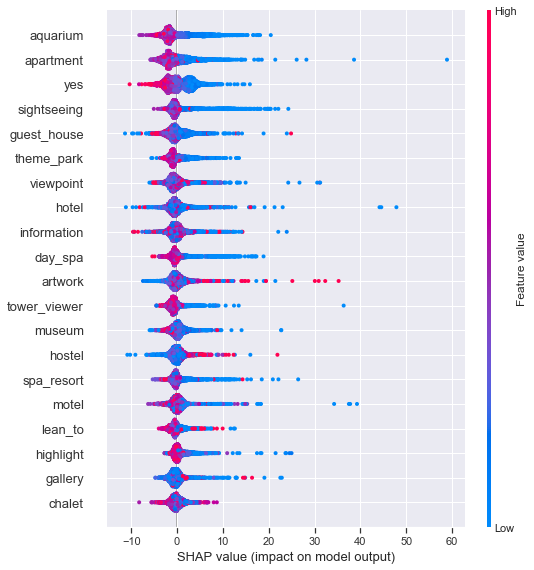

In [75]:
shap.summary_plot(shap_values, X_test)

In [76]:
explain_weights_catboost(catb=model, top=25)

Explanation(estimator='<catboost.core.CatBoostRegressor object at 0x7fc27a20b4a8>', description='CatBoost feature importances; \nvalues are numbers 0 <= x <= 1; all values sum to 1.', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='information', weight=0.074580275, std=None, value=None), FeatureWeight(feature='artwork', weight=0.06834143, std=None, value=None), FeatureWeight(feature='hotel', weight=0.06651825, std=None, value=None), FeatureWeight(feature='guest_house', weight=0.05877541, std=None, value=None), FeatureWeight(feature='viewpoint', weight=0.058000688, std=None, value=None), FeatureWeight(feature='apartment', weight=0.055606063, std=None, value=None), FeatureWeight(feature='gallery', weight=0.053161245, std=None, value=None), FeatureWeight(feature='museum', weight=0.050703675, std=None, value=None), FeatureWeight(feature='hostel', weight=0.046092268, std=None, value=None), FeatureWeight(feature='aquarium', weight=0.04396755, std=None, value=None), FeatureWeight(feature='picnic_site', weight=0.042292625, std=None, value=None), FeatureWeight(feature='sightseeing', weight=0.0377624, std=None, value=None), FeatureWeight(feature='attraction', weight=0.032531153, std=None, value=None), FeatureWeight(feature='yes', weight=0.032331828, std=None, value=None), FeatureWeight(feature='theme_park', weight=0.031025128, std=None, value=None), FeatureWeight(feature='spa_resort', weight=0.030552683, std=None, value=None), FeatureWeight(feature='highlight', weight=0.030193957, std=None, value=None), FeatureWeight(feature='motel', weight=0.028571859, std=None, value=None), FeatureWeight(feature='chalet', weight=0.027243864, std=None, value=None), FeatureWeight(feature='tower_viewer', weight=0.025362387, std=None, value=None), FeatureWeight(feature='day_spa', weight=0.024233801, std=None, value=None), FeatureWeight(feature='camp_site', weight=0.023947135, std=None, value=None), FeatureWeight(feature='caravan_site', weight=0.02362786, std=None, value=None), FeatureWeight(feature='zoo', weight=0.017376615, std=None, value=None), FeatureWeight(feature='lean_to', weight=0.017199865, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [78]:
# Прогноз модели на новых данных
def get_prediction(data_poi: pd.DataFrame, origin: tuple, model, feature_list, explainer):
    features = []
    for feature in feature_list:
        poi_coors = set(data_poi.get(feature))
        f = min([get_distance(origin, destination) for destination in poi_coors])
        features.append(f)
    return int(model.predict(features))

In [79]:
get_prediction(data_poi=poi_dict, origin=(52.534996, 13.417579), model=model, 
               feature_list=feature_list, explainer=explainer)

74

In [80]:
selected

['is_entire_apt',
 'hair_dryer',
 'lap_friendly',
 'Washer',
 'minimum_nights_more_1',
 'cleaning_fee',
 'accommodates',
 'host_is_superhost',
 'host_identity_verified',
 'instant_bookable',
 'cancellation_not_flexible',
 'size']

In [81]:
feature_list

['information',
 'artwork',
 'hotel',
 'motel',
 'viewpoint',
 'hostel',
 'museum',
 'yes',
 'attraction',
 'picnic_site',
 'guest_house',
 'gallery',
 'theme_park',
 'sightseeing',
 'chalet',
 'zoo',
 'camp_site',
 'highlight',
 'apartment',
 'aquarium',
 'spa_resort',
 'caravan_site',
 'tower_viewer',
 'day_spa',
 'lean_to']

In [82]:
features_to_scale = selected + feature_list


In [83]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledFeatures = sc.fit_transform(df_geo_features[features_to_scale])

In [84]:
X = scaledFeatures
y = df["price"]

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 3 xgboost

In [87]:
import xgboost as xgb

In [88]:
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [89]:
from sklearn import metrics

In [90]:
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[17:45:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 7, 'n_estimators': 120}


In [90]:
xgb_clf = xgb.XGBRegressor(n_estimators=120, max_depth=7)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
mae = metrics.mean_absolute_error(y_test, y_test_pred)
print("MAE:",mae)

[15:59:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score:  0.6160
RMSE:  26.3543
MAE: 15.251693238855292


# 3 svr

In [109]:
from sklearn.svm import SVR

In [92]:
#SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [93]:
y_pred2 = regressor.predict(X_test)

In [94]:
RMSE_svr = np.sqrt(mean_squared_error(y_test, y_pred2))
mae_svr = metrics.mean_absolute_error(y_test, y_pred2)
print("R^2 score: {0: .4f}".format(r2_score(y_test, y_pred2)))
print(f"RMSE: {round(RMSE_svr, 4)}")
print("MAE:",mae_svr)

R^2 score:  0.3825
RMSE: 33.4189
MAE: 18.68531821458217


# 3 RandomForest

In [95]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier

# Создаём модель леса из сотни деревьев
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
# Действующая классификация
rf_predictions = model.predict(X_test)
# Вероятности для каждого класса
rf_probs = model.predict_proba(X_test)[:, 1]

In [97]:
RMSE = np.sqrt(mean_squared_error(y_test, rf_predictions))
mae = metrics.mean_absolute_error(y_test, rf_predictions)
print("R^2 score: {0: .4f}".format(r2_score(y_test, rf_predictions)))
print(f"RMSE: {round(RMSE, 4)}")
print("MAE:",mae)

R^2 score:  0.3649
RMSE: 33.8908
MAE: 19.019990913221264


# 3 LinearRegression

In [91]:
from sklearn.linear_model import LinearRegression

In [92]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# регрессия
y_predict = linreg.predict(X_test)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(X_test, y_test)))

Accuracy of linear regression classifier on test set: 0.47


In [93]:
RMSE_lg = np.sqrt(mean_squared_error(y_test, y_predict))
mae_lg = metrics.mean_absolute_error(y_test, y_predict)
print("R^2 score: {0: .4f}".format(r2_score(y_test, y_predict)))
print(f"RMSE: {round(RMSE_lg, 4)}")
print("MAE:",mae_lg)

R^2 score:  0.4686
RMSE: 31.0009
MAE: 19.18558336661919


In [100]:
from sklearn.preprocessing import PolynomialFeatures

In [101]:
trans = PolynomialFeatures(degree=2)
PolyFeatures = trans.fit_transform(df_geo_features[features_to_scale])

In [102]:
X_p = PolyFeatures
y_p = df["price"]

In [103]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y_p, test_size=0.3, random_state=0)

# 4 xgboost

In [ ]:
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [97]:
xgb_clf = xgb.XGBRegressor(n_estimators=120, max_depth=7)
xgb_clf.fit(X_p_train, y_p_train)
y_p_test_pred = xgb_clf.predict(X_p_test)
print("R^2 score: {0: .4f}".format(r2_score(y_p_test, y_p_test_pred)))
print("RMSE: {0: .4f}".format(np.sqrt(mean_squared_error(y_p_test, y_p_test_pred))))
mae = metrics.mean_absolute_error(y_p_test, y_p_test_pred)
print("MAE:",mae)

[18:13:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score:  0.5968
RMSE:  27.0053
MAE: 15.67944869405841


# 4 LinearRegression

In [113]:
linreg = LinearRegression()
linreg.fit(X_p_train, y_p_train)
# регрессия
y_p_predict = linreg.predict(X_p_test)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(X_p_test, y_p_test)))

Accuracy of linear regression classifier on test set: 0.47


In [115]:
RMSE_lg = np.sqrt(mean_squared_error(y_p_test, y_p_predict))
mae_lg = metrics.mean_absolute_error(y_p_test, y_p_predict)
print("R^2 score: {0: .4f}".format(r2_score(y_p_test, y_p_predict)))
print(f"RMSE: {round(RMSE_lg, 4)}")
print("MAE:",mae_lg)

R^2 score:  0.4663
RMSE: 31.0685
MAE: 19.347809327645283


# 4 svr

In [110]:
#SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_p_train, y_p_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [106]:
y_p_pred2 = regressor.predict(X_p_test)

In [107]:
RMSE_svr = np.sqrt(mean_squared_error(y_p_test, y_p_pred2))
mae_svr = metrics.mean_absolute_error(y_p_test, y_p_pred2)
print("R^2 score: {0: .4f}".format(r2_score(y_p_test, y_p_pred2)))
print(f"RMSE: {round(RMSE_svr, 4)}")
print("MAE:",mae_svr)

R^2 score:  0.3523
RMSE: 34.2246
MAE: 19.830659654174617


# 4 RandomForest

In [108]:
from sklearn.ensemble import RandomForestClassifier

# Создаём модель леса из сотни деревьев
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(X_p_train, y_p_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [109]:
# Действующая классификация
rf_predictions = model.predict(X_p_test)
# Вероятности для каждого класса
rf_probs = model.predict_proba(X_p_test)[:, 1]

In [110]:
RMSE = np.sqrt(mean_squared_error(y_p_test, rf_predictions))
mae = metrics.mean_absolute_error(y_p_test, rf_predictions)
print("R^2 score: {0: .4f}".format(r2_score(y_test, rf_predictions)))
print(f"RMSE: {round(RMSE, 4)}")
print("MAE:",mae)

R^2 score:  0.3977
RMSE: 33.0039
MAE: 18.353021353930032


In [116]:
metrics = pd.read_excel('./metrics_2.xlsx')
metrics

Unnamed: 0 Feature Selection Data Unnamed: 2 Unnamed: 3 Polynominal Data Unnamed: 5 Unnamed: 6 POI dist Unnamed: 8 Unnamed: 9 Polynominal POI dist  Unnamed: 11 Unnamed: 12
0               NaN                     R2       RMSE        MAE               R2       RMSE        MAE       R2       RMSE        MAE                    R2        RMSE         MAE
1  LinearRegression                   0.44      31.66      19.61             0.49      30.30      18.78     0.46      31.00      19.18                  0.46       31.06       19.34
2               SVR                 0.4130    32.5832    18.3961           0.3059    35.4302    21.0012   0.3825    33.4189    18.6853                0.3523     34.2246     19.8306
3      RandomForest                 0.2836    35.9938     19.993           0.2737    36.2428    19.6768   0.3649    33.8908    19.0199                0.3977     33.0039     18.3530
4           xgboost                 0.6102    26.5518    15.2361           0.5960    27.0310    15.7016   0.6160    26.3543    15.2516                0.5968     27.0053     15.6794